# 1. Pre-processing: aligning the electrical signal with the channel values


In this notebook, we apply 1D linear regression in order to better align the signal and target.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

In [2]:
train = pd.read_csv('../data/train_clean.csv')
test = pd.read_csv('../data/test_clean.csv')

In [3]:
# The start of our batches (* 100_000)
BATCHES = np.array([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 65, 70])

# The data categories of our batches (5 of them have been identified in Chris Deotte 
# "One Feature Model notebook"). But we have noticed a 6th type in the test data.
CATEGORIES = np.array([1, 1, 2, 3, 5, 4, 2, 3, 4, 5, 6, 3, 4, 6, 2, 5, 4, 5, 6, 3, 6, 6])

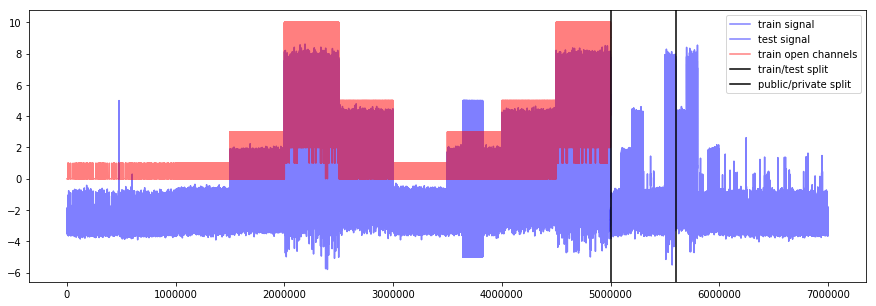

In [4]:
plt.figure(figsize=(15, 5))
plt.plot(train['signal'], label='train signal', c='b', alpha=0.5)
plt.plot(range(len(train), len(train) + len(test)), test['signal'], label='test signal', c='b', alpha=0.5)
plt.plot(train['open_channels'], c='r', label='train open channels', alpha=0.5)
plt.axvline(5_000_000, c='k', label='train/test split')
plt.axvline(5_600_000, c='k', label='public/private split')
plt.legend()
plt.show()

In [5]:
for c in range(1, 6):
    # Take the training data corresponding to this category
    ix = np.where(CATEGORIES[:-11] == c)[0]
    starts = BATCHES[ix]
    ends = BATCHES[ix + 1]
    X = []
    y = []
    for start, end in zip(starts, ends):
        subsignal = train['signal'].values[start*100_000:end*100_000]
        subtarget = train['open_channels'].values[start*100_000:end*100_000]
        
        # Skip the anomalous part between 3.6M - 3.9M
        if start == 35:
            subsignal = list(subsignal[:100_000]) + list(subsignal[-100_000:])
            subtarget = list(subtarget[:100_000]) + list(subtarget[-100_000:])
        
        X.extend(subsignal)
        y.extend(subtarget)
    X = np.array(X)
    y = np.array(y)
    
    # Create a dataframe with our values, than groupby the open channel
    # values and take the mean
    df = pd.DataFrame(np.hstack((X.reshape(-1, 1),
                                 y.reshape(-1, 1))),
                      columns=['X', 'y'])
    means = df.groupby('y')[['X']].mean()
    X = means['X'].values
    y = means.index.values
    
    # Fit Linear Regression on the means.
    lr = LinearRegression()
    lr.fit(X.reshape(-1, 1), y)
    print(c, lr.intercept_, lr.coef_)

1 2.204145338888899 [0.80862586]
2 2.216999195814381 [0.81071421]
3 2.2229470830947085 [0.81240389]
4 2.221043399988118 [0.80972639]
5 4.451422627735057 [0.80219267]


In [6]:
# As we tuned the entire pipeline during the competition, we also adjusted these
# values a little bit and checked the impact on our training F1 score. Below
# are our final values:
OFFSETS = [2.180783, 2.221318, 2.221318, 2.221318, 4.4288541, 2.221318]
SLOPE = 0.8107

signal = np.concatenate((train['signal'].values, test['signal'].values))
for i, (start, end) in enumerate(zip(BATCHES[:-1], BATCHES[1:])):
    c = CATEGORIES[i] - 1
    signal[start*100_000:end*100_000] = OFFSETS[c] + SLOPE * signal[start*100_000:end*100_000]

train['signal'] = signal[:5_000_000]
test['signal'] = signal[5_000_000:]

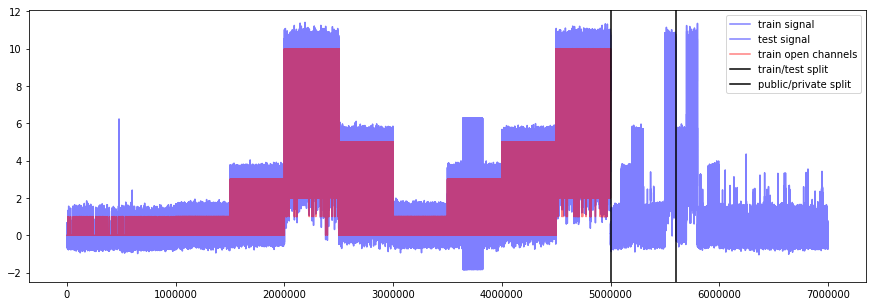

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(train['signal'], label='train signal', c='b', alpha=0.5)
plt.plot(range(len(train), len(train) + len(test)), test['signal'], label='test signal', c='b', alpha=0.5)
plt.plot(train['open_channels'], c='r', label='train open channels', alpha=0.5)
plt.axvline(5_000_000, c='k', label='train/test split')
plt.axvline(5_600_000, c='k', label='public/private split')
plt.legend()
plt.show()

In [8]:
# Let's check what our F1 score would be if we just round our signal values
good_ids = list(range(0, 3_600_000)) + list(range(3_900_000, 5_000_000))
f1_score(train['open_channels'].values[good_ids], 
         np.clip(np.round(train['signal'].values[good_ids]).astype(int), 0, 10), 
         average='macro')

0.9211271639823664

In [ ]:
train.to_csv('../data/train_1.csv', index=False)
test.to_csv('../data/test_1.csv', index=False)